## CHALLENGE DE INTELIGENCIA ARTIFICIAL - AUTOR: PABLO HERNÁN ILARDO

## A) Aspectos generales y de trabajo

#### Abreviaturas y definiciones

A lo largo del desarrollo utilizo las abreviaturas "trn" como 'training' o entrenamiento, "val" como 'validation' o validación y "tst" como test. También suelo utilizar la palabra "sample" para referirme a una muestra cualquiera de un dataset (en este caso, a una imagen). Estas abreviaturas aparecen en el texto y en la definición de variables para referirse a los distintos datasets utilizados.

#### Consideraciones generales de las distintas fases para la forma de trabajo planteada

1) En primer lugar estudié el tipo de imágenes y el número de muestras que tiene el dataset y separé los datasets para entrenamiento, validación y test con una proporción inicial de 80%, 10% y 10%, respectivamente, guardando las imágenes en carpetas separadas.

2) Después de armar los datasets para trn, val y tst, decidí plantear un modelo inicial o modelo base desarrollado en pytorch con las capas requeridas para analizar su respuesta.

3) A partir de ese momento, analizo la performance del entrenamiento respecto a la publicación de referencia y planteo como hipótesis cuál podría ser la causa de las divergencias detectadas.

4) A continuación, aplico modificaciones en el dataset y en el modelo planteado para tratar de mejorarlo.

5) Como paso final, analizo nuevamente la capacidad de predicción del modelo después de cada una de las modificaciones.

6) Por último, escribo las conclusiones que fui sacando del trabajo realizado.

## B) Desarrollo

### FASE 1: Desarrollo del modelo base

#### 1) Importación de las librerías que se van a utilizar durante el desarrollo

En caso de no tener las librerías instaladas, se las puede ir instalando corriendo "pip install librería_a_instalar".

In [1]:
## Importo las librerías que voy a usar en el transcurso del desarrollo

import os, time
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sn
import torch

from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from imutils import paths
import shutil

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

import cv2

#### 2) Definición de parámetros generales de los datasets y funciones utilitarias

In [2]:
## Defino los nombres de las rutas y tamaños de los datasets y de las imágenes
DATASET_PATH = "2750"
TRAIN = "train"
VAL = "val"
TST = "tst"
INPUT_HEIGHT = 64
INPUT_WIDTH = 64
BATCH_SIZE = 128
VAL_SPLIT = 0.1
TST_SPLIT = 0.1

In [3]:
## Definición de una función utitaria para dividir las imágenes en directorios para trn, val y tst
## Tomada de https://pyimagesearch.com/2021/10/04/image-data-loaders-in-pytorch/

def copy_images(imagePaths, folder):
    # check if the destination folder exists and if not create it
	if not os.path.exists(folder):
		os.makedirs(folder)
	# loop over the image paths
	for path in imagePaths:
		# grab image name and its label from the path and create
		# a placeholder corresponding to the separate label folder
		imageName = path.split(os.path.sep)[-1]
		label = path.split(os.path.sep)[-2]
		labelFolder = os.path.join(folder, label)
		# check to see if the label folder exists and if not create it
		if not os.path.exists(labelFolder):
			os.makedirs(labelFolder)
		# construct the destination image path and copy the current
		# image to it
		destination = os.path.join(labelFolder, imageName)
		shutil.copy(path, destination)

In [4]:
## Función para visualizar mini-batches de imágenes
## Adaptada de https://pyimagesearch.com/2021/10/04/image-data-loaders-in-pytorch/

def visualize_batch(batch, classes, dataset_type, BATCH_SIZE):
	# initialize a figure
	fig = plt.figure("{} batch".format(dataset_type),
		figsize=(BATCH_SIZE, BATCH_SIZE))
	# loop over the batch size
	for i in range(0, BATCH_SIZE):
		# create a subplot
		ax = plt.subplot(2, 4, i + 1)
		# grab the image, convert it from channels first ordering to
		# channels last ordering, and scale the raw pixel intensities
		# to the range [0, 255]
		image = batch[0][i].cpu().numpy()
		image = image.transpose((1, 2, 0))
		image = (image * 255.0).astype("uint8")
		# grab the label id and get the label from the classes list
		idx = batch[1][i]
		label = classes[idx]
		# show the image along with the label
		plt.imshow(image)
		plt.title(label)
		plt.axis("off")
	# show the plot
	plt.tight_layout()
	plt.show()

#### 3) Especificación de transformaciones para el dataset de trn y selección de samples para trn, val y tst

In [5]:
## Especificación de transformaciones para trn (no usamos para entrenar al modelo base)
## Para el caso de val y tst, no se aplican transformaciones.

resize = T.Resize(size=(INPUT_HEIGHT,INPUT_WIDTH))

trainTransforms = T.Compose([resize, T.ToTensor()])
valTransforms = T.Compose([resize, T.ToTensor()])
tstTransforms = T.Compose([resize, T.ToTensor()])

In [6]:
## Selección pseudoaleatoria de las imágenes para los datasets de trn, val y tst
imagePaths = list(paths.list_images(DATASET_PATH))
np.random.shuffle(imagePaths)

valPathsLen = int(len(imagePaths) * VAL_SPLIT)
tstPathsLen = int(len(imagePaths) * TST_SPLIT)
trainPathsLen = len(imagePaths) - valPathsLen - tstPathsLen
trainPaths = imagePaths[:trainPathsLen]
valPaths = imagePaths[trainPathsLen:-tstPathsLen]
tstPaths = imagePaths[-tstPathsLen:]

#### 4) Ubicación de los samples de trn, val y tst en carpetas separadas y creación de los datasets

In [7]:
## Separación de las imágenes en carpetas para trn, val y tst
copy_images(trainPaths, TRAIN)
copy_images(valPaths, VAL)
copy_images(tstPaths, TST)

In [8]:
## Creación de los datasets a partir de las carpetas de imágenes utilizando la función ImageFolder de pytorch
trainDataset = ImageFolder(root=TRAIN, transform=trainTransforms)
valDataset = ImageFolder(root=VAL, transform=valTransforms)
tstDataset = ImageFolder(root=TST, transform=tstTransforms)

In [9]:
## Verificación del tamaño de los datasets
N_trn = len(trainDataset)
N_val = len(valDataset)
N_tst = len(tstDataset)
N = N_trn + N_val + N_tst
print('Verificamos la cantidad de samples en trn, val y tst..')
print('N_trn: {0}\tN_val: {1}\t N_tst: {2}'.format(N_trn, N_val, N_tst))
print('Split_val: {0}\tSplit_tst: {1}'.format(N_val/N, N_tst/N))

Verificamos la cantidad de samples en trn, val y tst..
N_trn: 21600	N_val: 2700	 N_tst: 2700
Split_val: 0.1	Split_tst: 0.1


#### 5) Creación de los dataloaders de pytorch para los datasets y visualización de mini-batches

In [10]:
## Creación de los dataloaders asociados a los datasets
trainDataLoader = DataLoader(trainDataset, batch_size=BATCH_SIZE, shuffle=True)
valDataLoader = DataLoader(valDataset, batch_size=BATCH_SIZE, shuffle=True)
tstDataLoader = DataLoader(tstDataset, batch_size=BATCH_SIZE, shuffle=True)

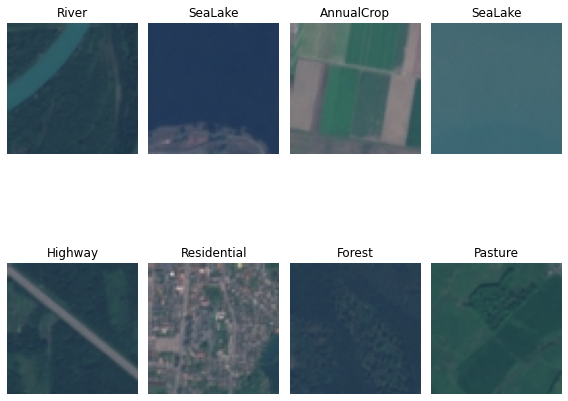

In [11]:
## Visualización de un mini-batch de trn de tamaño 8 para ver las imágenes
trainDataLoader = DataLoader(trainDataset, batch_size=8, shuffle=True)
trainBatch = next(iter(trainDataLoader))
visualize_batch(trainBatch, trainDataset.classes, "train", 8)

# Vuelvo a crear el dataloader con el tamaño de BATCH_SIZE elegido
trainDataLoader = DataLoader(trainDataset, batch_size=BATCH_SIZE, shuffle=True)

#### 6) Definición e instanciación del modelo pytorch base con las capas requeridas

In [12]:
## Definición del modelo tal como fue requerido

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn1=nn.BatchNorm2d(num_features=3)
        self.conv1=nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding = 'same')
        self.bn2=nn.BatchNorm2d(num_features=16)
        self.conv2=nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding = 'same')
        self.conv3=nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding = 'same')
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.conv4=nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding = 'same')
        self.conv5=nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding = 'same')
        self.fc1 = nn.Linear(4096, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
        
    def forward(self, x):
        x = self.bn1(x)
        x = self.conv1(x)
        x = F.elu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.bn2(x)
        x = self.conv2(x)
        x = F.elu(x)
        x = self.conv3(x)
        x = F.elu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.bn3(x)
        x = self.conv4(x)
        x = F.elu(x)
        x = self.conv5(x)
        x = F.elu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = torch.flatten(x, 1)               # Se achatan todas las dimensiones excepto la de batch
        x = self.fc1(x)
        x = F.elu(x)
        x = F.dropout(x, p=0.5)
        x = self.fc2(x)
        x = F.elu(x)
        x = F.dropout(x, p=0.5)
        x = self.fc3(x)                       # No agrego la salida softmax acá
                                              # Esto es porque la función de loss "torch.nn.CrossEntropyLoss()" ya la incorpora
        
        return x

In [13]:
model = Model()

#### 7) Definición de la función de entrenamiento

In [14]:
## Definición de la función para realizar el entrenamiento

def trn_function(training_epochs, learning_rate, criterion, optimizer, verbose=True, plot=True):
    
    ## Inicializo variables para el entrenamiento
    total_batch = len(trainDataset)//BATCH_SIZE

    train_cost = []
    train_accu = []

    trn_cost_epochs = []
    val_cost_epochs = []

    time_i = time.time()

    for epoch in range(training_epochs):                   ## Itero sobre el dataset un número determinado de veces (Épocas)
        avg_cost = 0

        for i, data in enumerate(trainDataLoader, 0):      ## Itero para tomar batches del dataset de training

            # Tomo las entradas y clases del batch de trn
            inputs, labels = data

            # Inicializo a cero los gradientes
            optimizer.zero_grad()

            # Predigo las salidas del modelo con las entradas del dataset
            outputs = model(inputs)

            # Aplico la función de pérdida o costo y optimizo calculando los gradientes
            cost = criterion(outputs, labels)
            cost.backward()
            optimizer.step()

            # Obtengo las clases predichas por el modelo
            prediction = outputs.data.max(dim=1)[1]

            # Calculo y guardo la exactitud y el costo de trn
            train_accu.append(((prediction.data == labels.data).float().mean()).item())
            train_cost.append(cost.item()) 

            # Muestro resultados cada 10 batches
            if i % 10 == 0 and verbose:
                print("Epoch= {},\t batch = {},\t cost = {:2.4f},\t accuracy = {}".format(epoch+1, i, train_cost[-1], train_accu[-1]))

            avg_cost += cost.data / total_batch


        # Anulo el cálculo de gradientes para evaluar el dataset de validation
        with torch.no_grad():
            val_accu = []
            val_cost = []
            for inputs_val, labels_val in valDataLoader:              ## Itero para tomar batches del dataset de validation
                outputs_val = model(inputs_val)
                cost_val = criterion(outputs_val, labels_val)
                val_cost.append(cost_val.item())

                # Obtengo los valores que el modelo predijo en val
                prediction_val = (torch.max(torch.exp(outputs_val),1))[1]

                # Calculo la exactitud para el dataset de val y guardo la información
                val_accuracy = ((prediction_val.data == labels_val.data).float().mean()).item()
                val_accu.append(val_accuracy)

        val_cost = np.mean(val_cost)
        val_accuracy = np.mean(val_accu)

        trn_cost_epochs.append(avg_cost.item())
        val_cost_epochs.append(val_cost)
        
        time_f = time.time()
        
        ## Imprimo resultados después de cada época
        if verbose:
            print("[Epoch: {:>4}], averaged cost = {:>.9}, val accuracy = {}, val cost = {}".format(epoch + 1, avg_cost.item(), val_accuracy, val_cost))
            print('time= ', (time_f-time_i)//60, 'min')

    ## Grafico resultados al final del entrenamiento
    if plot:
        plt.plot(trn_cost_epochs, 'r', label="trn")
        plt.plot(val_cost_epochs, 'g', label="val")
        plt.legend(loc="upper right")
        plt.title('Evolución de la función de pérdida durante el entrenamiento para trn y val')
        plt.xlabel("Época de entrenamiento")
        plt.ylabel("Pérdida")
        plt.show()
        
    ## Devuelvo las variables principales del entrenamiento
    return (trn_cost_epochs, val_cost_epochs, train_cost, train_accu)

#### 8) Definición de funciones utilitarias para medir la performance del modelo

In [15]:
## Definición de la función para la construcción de la matriz de confusión con los datos de tst

def crear_confusion_matrix(plot=True):
    
    y_true = []
    y_pred = []
    
    ## Itero sobre el dataset de test
    with torch.no_grad():
        for inputs, labels in tstDataLoader:
                output = model(inputs)
                output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
                y_pred.extend(output)
                labels = labels.data.cpu().numpy()
                y_true.extend(labels)


    # Genero la matriz de confusión
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix, axis=1), index = [i for i in trainDataset.classes],
                         columns = [i for i in trainDataset.classes])
    
    # Muestro el gráfico con los resultados
    plt.figure(figsize = (12,7))
    
    # Utilizo el mapa de colores típico que se suele mostrar
    sn.heatmap(df_cm, annot=True)
    
    return(y_true, y_pred)

In [16]:
## Definición de la función para calcular la performance del modelo con los datos de tst

def calcular_performance(y_true, y_pred, verbose = True):
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)
    accuracy_tst = accuracy_score(y_true, y_pred)
    
    if verbose:
        print('Performance del modelo para cada clase con el dataset de test\n')
        print('Precision: {} \n\nRecall: {}\n\nf1: {}\n\naccuracy: {}'.format(precision, recall, f1, accuracy_tst))
    
    return (precision, recall, f1, accuracy_tst)

#### 9) Especificación de los parámetros del modelo base y entrenamiento

Definimos parámetros usualmente adoptados para redes de convolución que conformen un modelo base y lo entrenamos por 50 épocas para ver los resultados

Como función de pérdida se escogió la función CrossEntropyLoss que calcula una distancia entre distribuciones de probabilidad discretas y suele ser la métrica inicial para utilizar en un problema multiclase como este.

Como optimizador se eligió "Adam" con un learning rate de 0.001. Adam es un algoritmo que permite actualizar los pesos de la red neuronal agregando momentum a los gradientes, y esto permite evitar mínimos locales de la función de pérdida y aprovechar el impulso que el propio entrenamiento tiene para seguir de largo en los mínimos locales y converger de una forma más directa a la solución. Suele ser muy utilizado, especialmente cuando la función de pérdida es muy caótica.

In [17]:
## Definición de los parámetros del modelo
training_epochs = 50
learning_rate = 0.001
## optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()   # La función softmax se calcula internamente en esta función de pérdida
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

Epoch= 1,	 batch = 0,	 cost = 2.3124,	 accuracy = 0.0546875
Epoch= 1,	 batch = 10,	 cost = 1.6790,	 accuracy = 0.3203125
Epoch= 1,	 batch = 20,	 cost = 1.5279,	 accuracy = 0.4296875
Epoch= 1,	 batch = 30,	 cost = 1.4482,	 accuracy = 0.4921875
Epoch= 1,	 batch = 40,	 cost = 1.3920,	 accuracy = 0.5078125
Epoch= 1,	 batch = 50,	 cost = 1.0899,	 accuracy = 0.609375
Epoch= 1,	 batch = 60,	 cost = 1.0193,	 accuracy = 0.6328125
Epoch= 1,	 batch = 70,	 cost = 0.9041,	 accuracy = 0.71875
Epoch= 1,	 batch = 80,	 cost = 0.9769,	 accuracy = 0.6796875
Epoch= 1,	 batch = 90,	 cost = 0.9396,	 accuracy = 0.6640625
Epoch= 1,	 batch = 100,	 cost = 0.8101,	 accuracy = 0.7421875
Epoch= 1,	 batch = 110,	 cost = 1.0945,	 accuracy = 0.5703125
Epoch= 1,	 batch = 120,	 cost = 1.1357,	 accuracy = 0.5703125
Epoch= 1,	 batch = 130,	 cost = 0.8440,	 accuracy = 0.6875
Epoch= 1,	 batch = 140,	 cost = 0.7344,	 accuracy = 0.7578125
Epoch= 1,	 batch = 150,	 cost = 0.9274,	 accuracy = 0.6171875
Epoch= 1,	 batch = 160,	 

Epoch= 8,	 batch = 30,	 cost = 0.3777,	 accuracy = 0.890625
Epoch= 8,	 batch = 40,	 cost = 0.4892,	 accuracy = 0.8671875
Epoch= 8,	 batch = 50,	 cost = 0.3992,	 accuracy = 0.8515625
Epoch= 8,	 batch = 60,	 cost = 0.2706,	 accuracy = 0.9375
Epoch= 8,	 batch = 70,	 cost = 0.2916,	 accuracy = 0.8515625
Epoch= 8,	 batch = 80,	 cost = 0.5236,	 accuracy = 0.8359375
Epoch= 8,	 batch = 90,	 cost = 0.3085,	 accuracy = 0.8828125
Epoch= 8,	 batch = 100,	 cost = 0.2462,	 accuracy = 0.9375
Epoch= 8,	 batch = 110,	 cost = 0.2562,	 accuracy = 0.90625
Epoch= 8,	 batch = 120,	 cost = 0.2700,	 accuracy = 0.8984375
Epoch= 8,	 batch = 130,	 cost = 0.3930,	 accuracy = 0.84375
Epoch= 8,	 batch = 140,	 cost = 0.2654,	 accuracy = 0.890625
Epoch= 8,	 batch = 150,	 cost = 0.2615,	 accuracy = 0.90625
Epoch= 8,	 batch = 160,	 cost = 0.3027,	 accuracy = 0.921875
[Epoch:    8], averaged cost = 0.319127142, val accuracy = 0.8493134460665963, val cost = 0.47702514177018945
time=  15.0 min
Epoch= 9,	 batch = 0,	 cost 

Epoch= 15,	 batch = 40,	 cost = 0.2064,	 accuracy = 0.9375
Epoch= 15,	 batch = 50,	 cost = 0.1285,	 accuracy = 0.9609375
Epoch= 15,	 batch = 60,	 cost = 0.2133,	 accuracy = 0.953125
Epoch= 15,	 batch = 70,	 cost = 0.0828,	 accuracy = 0.984375
Epoch= 15,	 batch = 80,	 cost = 0.1560,	 accuracy = 0.9453125
Epoch= 15,	 batch = 90,	 cost = 0.1177,	 accuracy = 0.9609375
Epoch= 15,	 batch = 100,	 cost = 0.1560,	 accuracy = 0.96875
Epoch= 15,	 batch = 110,	 cost = 0.0940,	 accuracy = 0.96875
Epoch= 15,	 batch = 120,	 cost = 0.1387,	 accuracy = 0.9609375
Epoch= 15,	 batch = 130,	 cost = 0.1581,	 accuracy = 0.953125
Epoch= 15,	 batch = 140,	 cost = 0.0962,	 accuracy = 0.9453125
Epoch= 15,	 batch = 150,	 cost = 0.0856,	 accuracy = 0.9765625
Epoch= 15,	 batch = 160,	 cost = 0.1984,	 accuracy = 0.9609375
[Epoch:   15], averaged cost = 0.163585633, val accuracy = 0.877959281206131, val cost = 0.4360677173191851
time=  29.0 min
Epoch= 16,	 batch = 0,	 cost = 0.0986,	 accuracy = 0.96875
Epoch= 16,	 ba

Epoch= 22,	 batch = 50,	 cost = 0.0429,	 accuracy = 0.9921875
Epoch= 22,	 batch = 60,	 cost = 0.1103,	 accuracy = 0.9609375
Epoch= 22,	 batch = 70,	 cost = 0.1509,	 accuracy = 0.953125
Epoch= 22,	 batch = 80,	 cost = 0.0650,	 accuracy = 0.9765625
Epoch= 22,	 batch = 90,	 cost = 0.1977,	 accuracy = 0.9375
Epoch= 22,	 batch = 100,	 cost = 0.1106,	 accuracy = 0.9453125
Epoch= 22,	 batch = 110,	 cost = 0.1123,	 accuracy = 0.96875
Epoch= 22,	 batch = 120,	 cost = 0.0831,	 accuracy = 0.9765625
Epoch= 22,	 batch = 130,	 cost = 0.1234,	 accuracy = 0.9609375
Epoch= 22,	 batch = 140,	 cost = 0.0944,	 accuracy = 0.96875
Epoch= 22,	 batch = 150,	 cost = 0.0934,	 accuracy = 0.9609375
Epoch= 22,	 batch = 160,	 cost = 0.1146,	 accuracy = 0.953125
[Epoch:   22], averaged cost = 0.112198271, val accuracy = 0.8832859857515856, val cost = 0.5588719607754187
time=  43.0 min
Epoch= 23,	 batch = 0,	 cost = 0.0618,	 accuracy = 0.984375
Epoch= 23,	 batch = 10,	 cost = 0.0945,	 accuracy = 0.953125
Epoch= 23,	 

Epoch= 29,	 batch = 50,	 cost = 0.0566,	 accuracy = 0.9765625
Epoch= 29,	 batch = 60,	 cost = 0.0922,	 accuracy = 0.984375
Epoch= 29,	 batch = 70,	 cost = 0.0395,	 accuracy = 0.984375
Epoch= 29,	 batch = 80,	 cost = 0.0264,	 accuracy = 0.984375
Epoch= 29,	 batch = 90,	 cost = 0.0390,	 accuracy = 0.984375
Epoch= 29,	 batch = 100,	 cost = 0.0573,	 accuracy = 0.984375
Epoch= 29,	 batch = 110,	 cost = 0.0554,	 accuracy = 0.9765625
Epoch= 29,	 batch = 120,	 cost = 0.0120,	 accuracy = 1.0
Epoch= 29,	 batch = 130,	 cost = 0.0095,	 accuracy = 1.0
Epoch= 29,	 batch = 140,	 cost = 0.0824,	 accuracy = 0.9765625
Epoch= 29,	 batch = 150,	 cost = 0.0423,	 accuracy = 0.9765625
Epoch= 29,	 batch = 160,	 cost = 0.0201,	 accuracy = 1.0
[Epoch:   29], averaged cost = 0.0755932406, val accuracy = 0.88873105970296, val cost = 0.5046229287981987
time=  56.0 min
Epoch= 30,	 batch = 0,	 cost = 0.0393,	 accuracy = 0.9921875
Epoch= 30,	 batch = 10,	 cost = 0.1838,	 accuracy = 0.9609375
Epoch= 30,	 batch = 20,	 

Epoch= 36,	 batch = 60,	 cost = 0.0327,	 accuracy = 0.9921875
Epoch= 36,	 batch = 70,	 cost = 0.0699,	 accuracy = 0.984375
Epoch= 36,	 batch = 80,	 cost = 0.1315,	 accuracy = 0.984375
Epoch= 36,	 batch = 90,	 cost = 0.2681,	 accuracy = 0.9375
Epoch= 36,	 batch = 100,	 cost = 0.1049,	 accuracy = 0.9609375
Epoch= 36,	 batch = 110,	 cost = 0.1892,	 accuracy = 0.9453125
Epoch= 36,	 batch = 120,	 cost = 0.0878,	 accuracy = 0.9765625
Epoch= 36,	 batch = 130,	 cost = 0.0566,	 accuracy = 0.9765625
Epoch= 36,	 batch = 140,	 cost = 0.0391,	 accuracy = 0.984375
Epoch= 36,	 batch = 150,	 cost = 0.0955,	 accuracy = 0.9609375
Epoch= 36,	 batch = 160,	 cost = 0.0534,	 accuracy = 0.9765625
[Epoch:   36], averaged cost = 0.086333096, val accuracy = 0.88873105970296, val cost = 0.548393575982614
time=  71.0 min
Epoch= 37,	 batch = 0,	 cost = 0.0418,	 accuracy = 0.984375
Epoch= 37,	 batch = 10,	 cost = 0.0139,	 accuracy = 1.0
Epoch= 37,	 batch = 20,	 cost = 0.0877,	 accuracy = 0.96875
Epoch= 37,	 batch =

Epoch= 43,	 batch = 70,	 cost = 0.0878,	 accuracy = 0.96875
Epoch= 43,	 batch = 80,	 cost = 0.0239,	 accuracy = 1.0
Epoch= 43,	 batch = 90,	 cost = 0.1264,	 accuracy = 0.9453125
Epoch= 43,	 batch = 100,	 cost = 0.0979,	 accuracy = 0.984375
Epoch= 43,	 batch = 110,	 cost = 0.0345,	 accuracy = 0.9921875
Epoch= 43,	 batch = 120,	 cost = 0.0305,	 accuracy = 0.9921875
Epoch= 43,	 batch = 130,	 cost = 0.0315,	 accuracy = 0.9921875
Epoch= 43,	 batch = 140,	 cost = 0.0542,	 accuracy = 0.96875
Epoch= 43,	 batch = 150,	 cost = 0.1850,	 accuracy = 0.9375
Epoch= 43,	 batch = 160,	 cost = 0.0195,	 accuracy = 0.9921875
[Epoch:   43], averaged cost = 0.0748792812, val accuracy = 0.8955965909090909, val cost = 0.6619928850030358
time=  85.0 min
Epoch= 44,	 batch = 0,	 cost = 0.0878,	 accuracy = 0.96875
Epoch= 44,	 batch = 10,	 cost = 0.1096,	 accuracy = 0.96875
Epoch= 44,	 batch = 20,	 cost = 0.1289,	 accuracy = 0.9765625
Epoch= 44,	 batch = 30,	 cost = 0.0348,	 accuracy = 0.9921875
Epoch= 44,	 batch 

Epoch= 50,	 batch = 80,	 cost = 0.0072,	 accuracy = 1.0
Epoch= 50,	 batch = 90,	 cost = 0.0019,	 accuracy = 1.0
Epoch= 50,	 batch = 100,	 cost = 0.0139,	 accuracy = 1.0
Epoch= 50,	 batch = 110,	 cost = 0.1358,	 accuracy = 0.9609375
Epoch= 50,	 batch = 120,	 cost = 0.0636,	 accuracy = 0.9765625
Epoch= 50,	 batch = 130,	 cost = 0.2322,	 accuracy = 0.9609375
Epoch= 50,	 batch = 140,	 cost = 0.0376,	 accuracy = 0.984375
Epoch= 50,	 batch = 150,	 cost = 0.0910,	 accuracy = 0.96875
Epoch= 50,	 batch = 160,	 cost = 0.0540,	 accuracy = 0.9765625
[Epoch:   50], averaged cost = 0.0569564402, val accuracy = 0.8804450766606764, val cost = 0.7270782400261272
time=  99.0 min


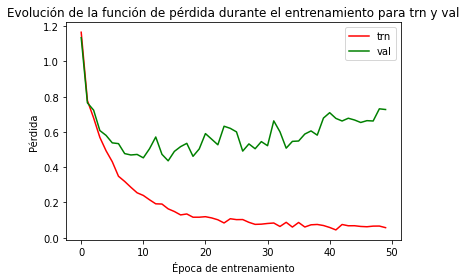

In [18]:
## Entrenamiento del modelo
trn_output = trn_function(training_epochs, learning_rate, criterion, optimizer, verbose=True, plot=True)

Si miramos la función de pérdida (loss o cost) para los datasets de trn y val, podemos ver que entre las 15-20 épocas el entrenamiento deja de verse reflejado en los datos de validation.

De hecho, si analizamos el accuracy para los datos de validation podemos ver que deja de crecer y la función de pérdida o costo se ameseta y comienza a aumentar, mientras que el accuracy para traning crece hasta alcanzar prácticamente el 100%.

Esto indica que, a partir del momento mencionado, el modelo alcanza su entrenamiento óptimo y se empieza a sobreeentrenar con los datos de training, memorizando casi la totalidad de los samples de trn y perdiendo capacidad de abstracción para seguir aprendiendo a predecir samples inpedendientes.

Si este modelo se fuera a utilizar para predicción, habría que entrenarlo aproximadamente 20 épocas y evaluar su performance a partir de ahí.

#### 10) Análisis de la matriz de confusión y de la performance del modelo

A) Genero una matriz de confusión para evaluar cómo predice el modelo las distintas clases con los datos de tst que no fueron evaluados previamente.

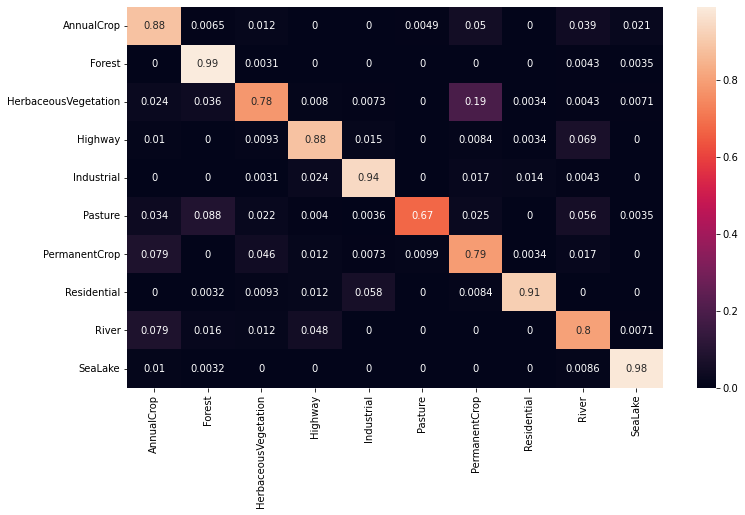

In [19]:
y_true, y_pred = crear_confusion_matrix(plot=True)

En la matriz de confusión vemos que existen clases que presentan errores bastante grandes, como por ejemplo las clases 3, 6 y 9, y al mismo tiempo hay un desbalance evidente en el aprendizaje de cada clase.

Tambien se puede ver que el algoritmo se confunde bastante entre las clases 3 y 6 (HerbaceousVegetation y PermanentCrop)

Esto se debe en parte a que el desbalance que tiene el dataset para algunas clases perjudica o sesga bastante el entrenamiento. Las clases menos entrenadas coinciden a su vez con las clases que menos samples tienen. Por ejemplo, la clase 6 (Pasture) tiene solamente 2000 samples, en un dataset con 27000 imágenes y 10 clases, que daría un promedio de 2700 samples por clase si estuvieran perfectamente equilibradas.

B) Obtengo algunos parémetros que definen la performance, como la precision, recall y f1 score para las distintas clases y la exactitud global  

In [20]:
performance = calcular_performance(y_true, y_pred, verbose=True)

Performance del modelo para cada clase con el dataset de test

Precision: [0.78899083 0.86647727 0.86896552 0.89156627 0.91197183 0.97857143
 0.72413793 0.97454545 0.79828326 0.95847751] 

Recall: [0.88356164 0.99025974 0.77777778 0.88446215 0.94181818 0.67487685
 0.79079498 0.91467577 0.80172414 0.97879859]

f1: [0.83360258 0.92424242 0.82084691 0.888      0.92665474 0.79883382
 0.756      0.94366197 0.8        0.96853147]

accuracy: 0.8714814814814815


Podemos ver que la performance general del modelo se encuentra bastante por debajo de los valores publicados en el paper, llegando a una exactitud del 88% para los datos de test, bastante lejos del mejor valor reportado en el paper, superior al 98%.

Cuando analizamos los valores de recall para las distintas clases, vemos que el modelo no está tratando de predecir todas las clases por igual. Las clases 3, 6 y 9 tienen valores muy bajos de recall, y esto significa que el modelo se arriesga poco a favor de estas clases.

C) Calculo los valores de AUC para cada clase, que sintetiza para cada clase la información del área bajo la curva ROC

Decidí utilizar esta métrica porque sintetiza la misma información que la familia de curvas ROC y los gráficos precision-recall en un solo número por clase. La métrica mAP en general se utiliza más para establecer la performance de algoritmos que seleccionan objetos en un fondo, y no lo veo tan util en este caso.

Valor del área bajo la curva ROC para cada clase: 

[0.92745358 0.98530546 0.88089226 0.93671862 0.96575445 0.8368377
 0.88076929 0.95588379 0.89134019 0.98691688]


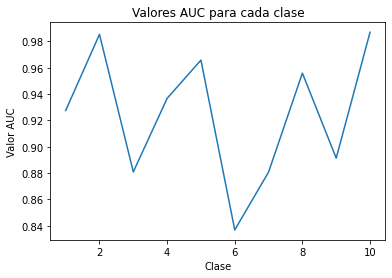

In [21]:
y_pred_one_hot = label_binarize(y_pred, classes=[*range(10)])
y_true_one_hot = label_binarize(y_true, classes=[*range(10)])

auc_v = roc_auc_score(y_true_one_hot, y_pred_one_hot, average=None)
print('Valor del área bajo la curva ROC para cada clase: \n\n{}'.format(auc_v))
plt.plot(np.arange(1,11), auc_v)
plt.title('Valores AUC para cada clase')
plt.xlabel("Clase")
plt.ylabel("Valor AUC")
plt.show()

De los valores de AUC para cada clase podemos notar existen clases más desfavorecidas que otras en el entrenamiento. La clase 6 nuevamente es una de las clases con menor métrica AUC y coincide con la clase que tiene menos samples y menores factores de recall y precision.

Para solucionar este problema podemos utilizar data augmentation y generar nuevos samples en las clases que tienen menos. Una vez balanceado el dataset con rotaciones, mirrors o translaciones, podemos entrenar nuevamente el modelo para analizar si el entrenamiento mejora. Además de mejorar el sesgo entre clases, se espera que el modelo sea más resistente al sobreentrenamiento, porque se le agrega una dificiltad considerable en la fase de entrenamiento.

#### 11) Comentarios acerca del desbalance entre clases

Si bien las clases en este conjunto de datos de imágenes están desbalanceadas y esto afecta al entrenamiento de las clases minoritarias en particular, no siempre uno quiere que todas las clases en un esquema estén entrenadas por igual.

En general, ocurre que algunas clases suelen ser más relevantes que otras en lo que respecta al negocio, por lo cual uno pone la atención y los recursos en tratar de predecir bien las clases que a uno más le interesan. Para ello se pueden pesar las clases más relevantes en el cálculo de la función de pérdida.

Como en este caso no hay información sobre la relevancia de las clases, supuse en el análisis que todas las clases son igual de importantes en relación al negocio y que todas deberían poder ser predecidas en forma similar por el modelo.

### FASE 2: Modificaciones en el dataset de trn

#### 1) Agregado de imagenes transformadas con data augmentation para balancear el dataset de trn

A) Definí en primer lugar la función 'transform_image' para aplicar transformadas de rotación y espejado utilizando OpenCV para Python y, de esta forma, tratar de balancear las clases para lograr un mejor entrenamiento.

In [22]:
## Especificación de la función para efectuar transformaciones sobre un sample cualquiera en la ruta 'path'
def transform_image(path):
    image = cv2.imread(path)
    rows, cols, dim = image.shape
    
    ## Defino un ángulo de rotación pseudoaleatorio entre 0º y 10º en cada sentido
    angulo_maximo_rotacion = 10
    angle_grados = angulo_maximo_rotacion*np.random.random()
    angle = np.radians(angle_grados)
    
    ## Defino una matriz de rotación en un sentido
    M_r_1 = np.float32([[np.cos(angle), -(np.sin(angle)), 0],
                        [np.sin(angle), np.cos(angle), 0],
                        [0, 0, 1]])
    
    ## Defino una matriz de rotación en sentido inverso
    M_r_2 = np.float32([[np.cos(angle), -(np.sin(-angle)), 0],
                        [np.sin(-angle), np.cos(angle), 0],
                        [0, 0, 1]])

    ## Defino una matriz de espejado alreredor del eje x
    M_x = np.float32([[1,  0, 0   ],
                      [0, -1, rows],
                      [0,  0, 1   ]])

    ## Defino una matriz de espejado alreredor del eje y
    M_y = np.float32([[-1, 0, cols],
                      [ 0, 1, 0   ],
                      [ 0, 0, 1   ]])
    
    ## Elijo para cada sample una matriz de transformación en forma pseudoaleatoria
    M = [M_r_1, M_r_2, M_x, M_y]
    idx = np.random.choice(len(M))

    ## Elijo para cada sample rotación en una dirección o en otra, o bien espejado respecto al exe x o y
    M_ = M[idx]

    ## Aplico la transformación con OpenCV
    transformed_img = cv2.warpPerspective(image, M_, (int(cols),int(rows)))
    
    ## Modifico el número de la imagen y guardo el archivo
    path_split_v = path.split('_')
    new_path = path_split_v[0] + '_' + str(int(path_split_v[-1][:-4])+1000000) + path_split_v[-1][-4:]
    cv2.imwrite(new_path, transformed_img)

B) En segundo lugar calculé cuáles son las clases desbalanceadas de trn y les apliqué la transformación con OpenCV generando nuevos samples

In [23]:
## El porcentaje de incremento indica cuánto sería incrementada cada clase 
## 100% implica que todas las clases quedarían con la misma cantidad de samples que la clase que más tiene.
porcentaje_incremento_samples=100

dir_classes = os.listdir(TRAIN)

## Calculamos la cantidad máxima de samples en la clase que mas tiene para trn
len_v = []
for dir in dir_classes:
    len_v.append(len(os.listdir(TRAIN + '/' + dir)))

max_num_clases = np.max(len_v)
print('Max. cantidad de samples de la clase de trn que mas samples tiene:', max_num_clases)

## Agregamos samples rotados o espejados a las clases que les faltan en trn
print('\nAgregando samples para compensar en trn con transformaciones de rotación y espejado..')
for i_dir in range(len(dir_classes)):
    i=0
    N=int((max_num_clases - len_v[i_dir])*porcentaje_incremento_samples/100)
    for path in os.listdir(TRAIN + '/' + dir_classes[i_dir]):
        if i<N:
            transform_image(TRAIN + '/' + dir_classes[i_dir] + '/' + path)
            i+=1

## Verificamos que las clases queden mejor balanceadas para trn
print('\nVerificamos que las clases queden mejor balanceadas para trn..')
len_v = []
for dir in dir_classes:
    len_v.append(len(os.listdir(TRAIN + '/' + dir)))

max_num_clases = np.max(len_v)
min_num_clases = np.min(len_v)
print('Max. cantidad de samples:', max_num_clases)
print('Min. cantidad de samples:', min_num_clases)

Max. cantidad de samples de la clase de trn que mas samples tiene: 2441

Agregando samples para compensar en trn con transformaciones de rotación y espejado..

Verificamos que las clases queden mejor balanceadas para trn..
Max. cantidad de samples: 2441
Min. cantidad de samples: 2441


#### 2) Definición del dataset y dataloader de trn

In [24]:
## Aplicamos esta vez transformaciones adicionales al dataset de trn con herramientas de pytorch
resize = T.Resize(size=(INPUT_HEIGHT,INPUT_WIDTH))
hFlip = T.RandomHorizontalFlip(p=0.25)
vFlip = T.RandomVerticalFlip(p=0.25)
rotate = T.RandomRotation(degrees=15)

trainTransforms = T.Compose([resize, hFlip, vFlip, rotate, T.ToTensor()])

## Creación de los datasets a partir de las carpetas de imágenes
trainDataset = ImageFolder(root=TRAIN, transform=trainTransforms)
trainDataLoader = DataLoader(trainDataset, batch_size=BATCH_SIZE, shuffle=True)

#### 3) Definición y entrenamiento del modelo base con clases balanceadas

In [25]:
training_epochs = 50

model = Model()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

Epoch= 1,	 batch = 0,	 cost = 2.3036,	 accuracy = 0.1171875
Epoch= 1,	 batch = 10,	 cost = 1.8724,	 accuracy = 0.2890625
Epoch= 1,	 batch = 20,	 cost = 1.5251,	 accuracy = 0.453125
Epoch= 1,	 batch = 30,	 cost = 1.2976,	 accuracy = 0.5703125
Epoch= 1,	 batch = 40,	 cost = 1.6482,	 accuracy = 0.515625
Epoch= 1,	 batch = 50,	 cost = 1.3448,	 accuracy = 0.5546875
Epoch= 1,	 batch = 60,	 cost = 1.3064,	 accuracy = 0.5390625
Epoch= 1,	 batch = 70,	 cost = 1.1026,	 accuracy = 0.640625
Epoch= 1,	 batch = 80,	 cost = 1.1274,	 accuracy = 0.625
Epoch= 1,	 batch = 90,	 cost = 0.9910,	 accuracy = 0.671875
Epoch= 1,	 batch = 100,	 cost = 0.9931,	 accuracy = 0.6484375
Epoch= 1,	 batch = 110,	 cost = 1.1039,	 accuracy = 0.6015625
Epoch= 1,	 batch = 120,	 cost = 0.9648,	 accuracy = 0.640625
Epoch= 1,	 batch = 130,	 cost = 1.0257,	 accuracy = 0.6171875
Epoch= 1,	 batch = 140,	 cost = 0.9308,	 accuracy = 0.6875
Epoch= 1,	 batch = 150,	 cost = 1.2737,	 accuracy = 0.59375
Epoch= 1,	 batch = 160,	 cost = 1

Epoch= 7,	 batch = 30,	 cost = 0.5280,	 accuracy = 0.8359375
Epoch= 7,	 batch = 40,	 cost = 0.5146,	 accuracy = 0.8125
Epoch= 7,	 batch = 50,	 cost = 0.6433,	 accuracy = 0.7578125
Epoch= 7,	 batch = 60,	 cost = 0.5778,	 accuracy = 0.828125
Epoch= 7,	 batch = 70,	 cost = 0.6506,	 accuracy = 0.734375
Epoch= 7,	 batch = 80,	 cost = 0.6340,	 accuracy = 0.8203125
Epoch= 7,	 batch = 90,	 cost = 0.5620,	 accuracy = 0.8046875
Epoch= 7,	 batch = 100,	 cost = 0.7819,	 accuracy = 0.75
Epoch= 7,	 batch = 110,	 cost = 0.6086,	 accuracy = 0.7734375
Epoch= 7,	 batch = 120,	 cost = 0.4824,	 accuracy = 0.84375
Epoch= 7,	 batch = 130,	 cost = 0.4783,	 accuracy = 0.8515625
Epoch= 7,	 batch = 140,	 cost = 0.5650,	 accuracy = 0.8203125
Epoch= 7,	 batch = 150,	 cost = 0.4116,	 accuracy = 0.859375
Epoch= 7,	 batch = 160,	 cost = 0.5454,	 accuracy = 0.84375
Epoch= 7,	 batch = 170,	 cost = 0.4516,	 accuracy = 0.828125
Epoch= 7,	 batch = 180,	 cost = 0.6371,	 accuracy = 0.796875
Epoch= 7,	 batch = 190,	 cost = 

Epoch= 13,	 batch = 40,	 cost = 0.3713,	 accuracy = 0.875
Epoch= 13,	 batch = 50,	 cost = 0.3811,	 accuracy = 0.8828125
Epoch= 13,	 batch = 60,	 cost = 0.3627,	 accuracy = 0.8828125
Epoch= 13,	 batch = 70,	 cost = 0.2909,	 accuracy = 0.890625
Epoch= 13,	 batch = 80,	 cost = 0.3462,	 accuracy = 0.890625
Epoch= 13,	 batch = 90,	 cost = 0.4200,	 accuracy = 0.8828125
Epoch= 13,	 batch = 100,	 cost = 0.3668,	 accuracy = 0.875
Epoch= 13,	 batch = 110,	 cost = 0.3732,	 accuracy = 0.859375
Epoch= 13,	 batch = 120,	 cost = 0.2137,	 accuracy = 0.9453125
Epoch= 13,	 batch = 130,	 cost = 0.3515,	 accuracy = 0.890625
Epoch= 13,	 batch = 140,	 cost = 0.2393,	 accuracy = 0.90625
Epoch= 13,	 batch = 150,	 cost = 0.3058,	 accuracy = 0.90625
Epoch= 13,	 batch = 160,	 cost = 0.1984,	 accuracy = 0.953125
Epoch= 13,	 batch = 170,	 cost = 0.4188,	 accuracy = 0.8828125
Epoch= 13,	 batch = 180,	 cost = 0.4831,	 accuracy = 0.8515625
Epoch= 13,	 batch = 190,	 cost = 0.3582,	 accuracy = 0.855555534362793
[Epoch:

Epoch= 19,	 batch = 40,	 cost = 0.1932,	 accuracy = 0.9453125
Epoch= 19,	 batch = 50,	 cost = 0.2899,	 accuracy = 0.9296875
Epoch= 19,	 batch = 60,	 cost = 0.2816,	 accuracy = 0.921875
Epoch= 19,	 batch = 70,	 cost = 0.3220,	 accuracy = 0.890625
Epoch= 19,	 batch = 80,	 cost = 0.2845,	 accuracy = 0.8984375
Epoch= 19,	 batch = 90,	 cost = 0.2951,	 accuracy = 0.8984375
Epoch= 19,	 batch = 100,	 cost = 0.2252,	 accuracy = 0.9140625
Epoch= 19,	 batch = 110,	 cost = 0.3308,	 accuracy = 0.90625
Epoch= 19,	 batch = 120,	 cost = 0.2734,	 accuracy = 0.90625
Epoch= 19,	 batch = 130,	 cost = 0.3415,	 accuracy = 0.9375
Epoch= 19,	 batch = 140,	 cost = 0.2443,	 accuracy = 0.921875
Epoch= 19,	 batch = 150,	 cost = 0.3530,	 accuracy = 0.8828125
Epoch= 19,	 batch = 160,	 cost = 0.2449,	 accuracy = 0.9140625
Epoch= 19,	 batch = 170,	 cost = 0.3317,	 accuracy = 0.921875
Epoch= 19,	 batch = 180,	 cost = 0.2302,	 accuracy = 0.921875
Epoch= 19,	 batch = 190,	 cost = 0.2734,	 accuracy = 0.9111111164093018
[

Epoch= 25,	 batch = 40,	 cost = 0.1915,	 accuracy = 0.9375
Epoch= 25,	 batch = 50,	 cost = 0.2894,	 accuracy = 0.8828125
Epoch= 25,	 batch = 60,	 cost = 0.2435,	 accuracy = 0.921875
Epoch= 25,	 batch = 70,	 cost = 0.3819,	 accuracy = 0.8828125
Epoch= 25,	 batch = 80,	 cost = 0.1364,	 accuracy = 0.9453125
Epoch= 25,	 batch = 90,	 cost = 0.3237,	 accuracy = 0.9140625
Epoch= 25,	 batch = 100,	 cost = 0.2336,	 accuracy = 0.9140625
Epoch= 25,	 batch = 110,	 cost = 0.3725,	 accuracy = 0.8671875
Epoch= 25,	 batch = 120,	 cost = 0.2095,	 accuracy = 0.921875
Epoch= 25,	 batch = 130,	 cost = 0.2393,	 accuracy = 0.9296875
Epoch= 25,	 batch = 140,	 cost = 0.2976,	 accuracy = 0.8828125
Epoch= 25,	 batch = 150,	 cost = 0.2111,	 accuracy = 0.953125
Epoch= 25,	 batch = 160,	 cost = 0.1343,	 accuracy = 0.953125
Epoch= 25,	 batch = 170,	 cost = 0.2262,	 accuracy = 0.9453125
Epoch= 25,	 batch = 180,	 cost = 0.1927,	 accuracy = 0.9609375
Epoch= 25,	 batch = 190,	 cost = 0.3402,	 accuracy = 0.8777777552604

Epoch= 31,	 batch = 40,	 cost = 0.1337,	 accuracy = 0.953125
Epoch= 31,	 batch = 50,	 cost = 0.1913,	 accuracy = 0.9375
Epoch= 31,	 batch = 60,	 cost = 0.1692,	 accuracy = 0.9609375
Epoch= 31,	 batch = 70,	 cost = 0.3409,	 accuracy = 0.8984375
Epoch= 31,	 batch = 80,	 cost = 0.1608,	 accuracy = 0.9453125
Epoch= 31,	 batch = 90,	 cost = 0.1376,	 accuracy = 0.9453125
Epoch= 31,	 batch = 100,	 cost = 0.0870,	 accuracy = 0.9609375
Epoch= 31,	 batch = 110,	 cost = 0.2346,	 accuracy = 0.921875
Epoch= 31,	 batch = 120,	 cost = 0.1366,	 accuracy = 0.953125
Epoch= 31,	 batch = 130,	 cost = 0.1470,	 accuracy = 0.953125
Epoch= 31,	 batch = 140,	 cost = 0.1066,	 accuracy = 0.96875
Epoch= 31,	 batch = 150,	 cost = 0.1641,	 accuracy = 0.9609375
Epoch= 31,	 batch = 160,	 cost = 0.1438,	 accuracy = 0.9296875
Epoch= 31,	 batch = 170,	 cost = 0.1497,	 accuracy = 0.9375
Epoch= 31,	 batch = 180,	 cost = 0.2479,	 accuracy = 0.9140625
Epoch= 31,	 batch = 190,	 cost = 0.0589,	 accuracy = 0.9888888597488403
[

Epoch= 37,	 batch = 40,	 cost = 0.2915,	 accuracy = 0.9296875
Epoch= 37,	 batch = 50,	 cost = 0.1626,	 accuracy = 0.953125
Epoch= 37,	 batch = 60,	 cost = 0.4197,	 accuracy = 0.9296875
Epoch= 37,	 batch = 70,	 cost = 0.3054,	 accuracy = 0.8984375
Epoch= 37,	 batch = 80,	 cost = 0.1850,	 accuracy = 0.9453125
Epoch= 37,	 batch = 90,	 cost = 0.1625,	 accuracy = 0.9375
Epoch= 37,	 batch = 100,	 cost = 0.1836,	 accuracy = 0.9375
Epoch= 37,	 batch = 110,	 cost = 0.0445,	 accuracy = 0.9921875
Epoch= 37,	 batch = 120,	 cost = 0.1694,	 accuracy = 0.9375
Epoch= 37,	 batch = 130,	 cost = 0.1377,	 accuracy = 0.953125
Epoch= 37,	 batch = 140,	 cost = 0.0940,	 accuracy = 0.96875
Epoch= 37,	 batch = 150,	 cost = 0.0981,	 accuracy = 0.9609375
Epoch= 37,	 batch = 160,	 cost = 0.1251,	 accuracy = 0.9375
Epoch= 37,	 batch = 170,	 cost = 0.2260,	 accuracy = 0.9296875
Epoch= 37,	 batch = 180,	 cost = 0.2000,	 accuracy = 0.96875
Epoch= 37,	 batch = 190,	 cost = 0.1953,	 accuracy = 0.9222221970558167
[Epoch:

Epoch= 43,	 batch = 50,	 cost = 0.2073,	 accuracy = 0.953125
Epoch= 43,	 batch = 60,	 cost = 0.1067,	 accuracy = 0.96875
Epoch= 43,	 batch = 70,	 cost = 0.0840,	 accuracy = 0.953125
Epoch= 43,	 batch = 80,	 cost = 0.1985,	 accuracy = 0.9453125
Epoch= 43,	 batch = 90,	 cost = 0.1689,	 accuracy = 0.9375
Epoch= 43,	 batch = 100,	 cost = 0.2026,	 accuracy = 0.9296875
Epoch= 43,	 batch = 110,	 cost = 0.2351,	 accuracy = 0.9140625
Epoch= 43,	 batch = 120,	 cost = 0.2203,	 accuracy = 0.921875
Epoch= 43,	 batch = 130,	 cost = 0.2758,	 accuracy = 0.9453125
Epoch= 43,	 batch = 140,	 cost = 0.1276,	 accuracy = 0.96875
Epoch= 43,	 batch = 150,	 cost = 0.1735,	 accuracy = 0.9453125
Epoch= 43,	 batch = 160,	 cost = 0.1367,	 accuracy = 0.9609375
Epoch= 43,	 batch = 170,	 cost = 0.1539,	 accuracy = 0.9609375
Epoch= 43,	 batch = 180,	 cost = 0.1674,	 accuracy = 0.953125
Epoch= 43,	 batch = 190,	 cost = 0.1144,	 accuracy = 0.9444444179534912
[Epoch:   43], averaged cost = 0.17834045, val accuracy = 0.90

Epoch= 49,	 batch = 50,	 cost = 0.0762,	 accuracy = 0.9765625
Epoch= 49,	 batch = 60,	 cost = 0.2051,	 accuracy = 0.953125
Epoch= 49,	 batch = 70,	 cost = 0.3036,	 accuracy = 0.9296875
Epoch= 49,	 batch = 80,	 cost = 0.1535,	 accuracy = 0.953125
Epoch= 49,	 batch = 90,	 cost = 0.1198,	 accuracy = 0.953125
Epoch= 49,	 batch = 100,	 cost = 0.1842,	 accuracy = 0.9765625
Epoch= 49,	 batch = 110,	 cost = 0.1580,	 accuracy = 0.96875
Epoch= 49,	 batch = 120,	 cost = 0.1221,	 accuracy = 0.96875
Epoch= 49,	 batch = 130,	 cost = 0.2209,	 accuracy = 0.921875
Epoch= 49,	 batch = 140,	 cost = 0.1701,	 accuracy = 0.9609375
Epoch= 49,	 batch = 150,	 cost = 0.2210,	 accuracy = 0.953125
Epoch= 49,	 batch = 160,	 cost = 0.1103,	 accuracy = 0.9609375
Epoch= 49,	 batch = 170,	 cost = 0.1124,	 accuracy = 0.953125
Epoch= 49,	 batch = 180,	 cost = 0.2257,	 accuracy = 0.9375
Epoch= 49,	 batch = 190,	 cost = 0.1393,	 accuracy = 0.9333333373069763
[Epoch:   49], averaged cost = 0.171563968, val accuracy = 0.916

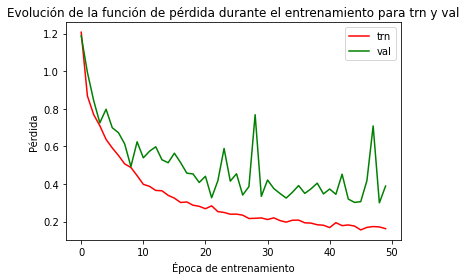

In [26]:
## Entrenamiento del modelo
trn_output = trn_function(training_epochs, learning_rate, criterion, optimizer, verbose=True, plot=True)

Si analizamos la evolución de la función de pérdida o costo a lo largo del entrenamiento, podemos ver que el loss para trn desciende más lentamente que en el caso del dataset sin data augmentation. Por otro lado, si miramos el loss para los datos de validation, podemos notar que no existe un quiebre alrededor de las 20 épocas, sino que la función de pérdida continúa bajando hasta las 50 épocas. Esto implica que se logró evitar el sobreentrenamiento u overfitting que existía antes.

El mismo efecto recién mencionado se puede ver en el accuracy del modelo con los datos de validation. Hacia el final del entrenamiento, se logra un accuracy de mas del 90%.

Como el modelo resiste el sobreentrenamiento y se puede serguir entrenando por más épocas, es factible que el factor de accuracy pueda subir aún más.

#### 4) Análisis de la matriz de confusión y performance del modelo para el dataset de tst

A) Genero una matriz de confusión para evaluar cómo predice el modelo las distintas clases

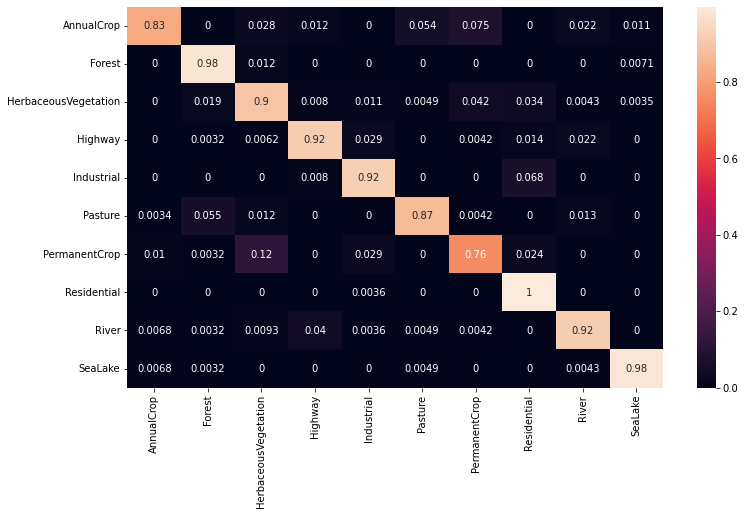

In [27]:
y_true, y_pred = crear_confusion_matrix(plot=True)

Del análisis de la matriz de confusión, podemos ver que mejoran significativamente las predicciones para las clases que estaban desbalanceadas a partir de la técnica de data augmentation. Por ejemplo, la clase 6 que era la más desfavorecida, acierta el 87% de las veces en las que el modelo se arriesga por esta clase, en contraste con el 67% de la matriz de confusión anterior. También podemos ver que el modelo se confunde menos entre las distintas clases porque los valores fuera de la diagonal son menores en casi todos los casos. De hecho, podemos ver a simple vista si miramos fuera de la diagonal que hay mucha más cantidad de ceros en la matriz ahora obtenida respecto a la primera.

También se puede notar que la confusión entre las clases 3 y 6 disminuye.

B) Obtengo algunos parémetros que definen la performance, como la precision, recall y f1 score para las distintas clases y la exactitud global  

In [28]:
performance = calcular_performance(y_true, y_pred, verbose=True)

Performance del modelo para cada clase con el dataset de test

Precision: [0.96812749 0.91793313 0.82621083 0.93117409 0.92335766 0.92670157
 0.85377358 0.87687688 0.93421053 0.97887324] 

Recall: [0.83219178 0.98051948 0.89506173 0.91633466 0.92       0.87192118
 0.75732218 0.99658703 0.91810345 0.98233216]

f1: [0.89502762 0.94819466 0.85925926 0.92369478 0.92167577 0.89847716
 0.80266075 0.93290735 0.92608696 0.98059965]

accuracy: 0.9107407407407407


Se puede notar en los parámetros de performance que el factor de recall aumenta bastante para las clases minorotarias respecto a los que se obtuvieron anteriormente. La precisión para las clases también presenta valores superiores y la exactitud global para los datos de tst aumenta del 87% al 91%. El factor f1 también mejora para varias clases al mejorar el recall y la presición.

C) Calculo nuevamente los valores de AUC para cada clase

Valor del área bajo la curva ROC para cada clase: 

[0.91443476 0.98461593 0.93469416 0.95469653 0.9556701  0.93315723
 0.87236284 0.98977669 0.95601283 0.98992487]


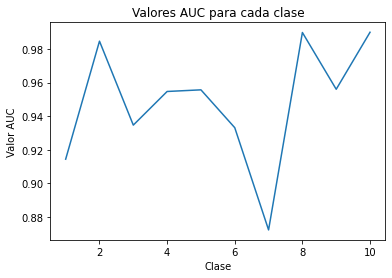

In [29]:
y_pred_one_hot = label_binarize(y_pred, classes=[*range(10)])
y_true_one_hot = label_binarize(y_true, classes=[*range(10)])

auc_v = roc_auc_score(y_true_one_hot, y_pred_one_hot, average=None)
print('Valor del área bajo la curva ROC para cada clase: \n\n{}'.format(auc_v))
plt.plot(np.arange(1,11), auc_v)
plt.title('Valores AUC para cada clase')
plt.xlabel("Clase")
plt.ylabel("Valor AUC")
plt.show()

Del análisis de los valores AUC podemos ver que la dispersión entre clases es menor a la que se podía ver sin data agumentation y que las clases con problemas (como la clase 6 o la 9 por ej.) mejoraron notablemente.

### FASE 3: Modificaciones al modelo base

#### 1) Definición del modelo

Agrego dos capas de convolución adicionales al modelo base para darle más profundidad a los mapas de activación de la red de convolución e intentar que el modelo pueda encontrar patrones más complejos en las imágenes. Es decir, intento que existan volúmenes de activación más profundos antes de ingresar a las capas full connected o dense para asociar todas las variables de las features anteriores.

Me hubiese gustado agregar también una capa más de neuronas full conected en la parte final del esquema, pero no lo voy a intentar por una cuestión del tiempo de cálculo que representaría.

In [30]:
## Definición del modelo modificado
class ModifiedModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn1=nn.BatchNorm2d(num_features=3)
        self.conv1=nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding = 'same')
        self.bn2=nn.BatchNorm2d(num_features=16)
        self.conv2=nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding = 'same')
        self.conv3=nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding = 'same')
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.conv4=nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding = 'same')
        self.conv5=nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding = 'same')
        self.bn4=nn.BatchNorm2d(num_features=64)
        self.conv6=nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding = 'same')
        self.conv7=nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding = 'same')
        self.fc1 = nn.Linear(8192, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
        
    def forward(self, x):
        x = self.bn1(x)
        x = self.conv1(x)
        x = F.elu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.bn2(x)
        x = self.conv2(x)
        x = F.elu(x)
        x = self.conv3(x)
        x = F.elu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.bn3(x)
        x = self.conv4(x)
        x = F.elu(x)
        x = self.conv5(x)
        x = F.elu(x)
        x = self.bn4(x)                      ## >> Capa agregada
        x = self.conv6(x)                    ## >> Capa agregada
        x = F.elu(x)                         ## >> Activación agregada
        x = self.conv7(x)                    ## >> Capa agregada
        x = F.elu(x)                         ## >> Activación agregada
        x = F.max_pool2d(x, kernel_size=2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.elu(x)
        x = F.dropout(x, p=0.5)
        x = self.fc2(x)
        x = F.elu(x)
        x = F.dropout(x, p=0.5)
        x = self.fc3(x)
        return x

#### 2) Entrenamiento del modelo

Defino los parámetros de entrenamiento y a continuación entreno el modelo utilizando el dataset de trn con data augmentation y con la misma cantidad de épocas que el anterior.

In [31]:
## Considero menos épocas para el entrenamiento porque el modelo tiene más profundidad
## Es probable que con 30 épocas el modelo se pueda entrenar bien en un tiempo acotado
training_epochs = 30

model = ModifiedModel()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

Epoch= 1,	 batch = 0,	 cost = 2.3100,	 accuracy = 0.1015625
Epoch= 1,	 batch = 10,	 cost = 1.7243,	 accuracy = 0.3671875
Epoch= 1,	 batch = 20,	 cost = 1.4939,	 accuracy = 0.453125
Epoch= 1,	 batch = 30,	 cost = 1.5774,	 accuracy = 0.40625
Epoch= 1,	 batch = 40,	 cost = 1.7678,	 accuracy = 0.359375
Epoch= 1,	 batch = 50,	 cost = 1.3162,	 accuracy = 0.4921875
Epoch= 1,	 batch = 60,	 cost = 1.2955,	 accuracy = 0.4765625
Epoch= 1,	 batch = 70,	 cost = 1.7020,	 accuracy = 0.375
Epoch= 1,	 batch = 80,	 cost = 1.3495,	 accuracy = 0.5
Epoch= 1,	 batch = 90,	 cost = 1.2799,	 accuracy = 0.5390625
Epoch= 1,	 batch = 100,	 cost = 1.1499,	 accuracy = 0.5625
Epoch= 1,	 batch = 110,	 cost = 1.1635,	 accuracy = 0.6640625
Epoch= 1,	 batch = 120,	 cost = 0.8870,	 accuracy = 0.65625
Epoch= 1,	 batch = 130,	 cost = 1.1548,	 accuracy = 0.59375
Epoch= 1,	 batch = 140,	 cost = 1.4119,	 accuracy = 0.5390625
Epoch= 1,	 batch = 150,	 cost = 1.2028,	 accuracy = 0.5546875
Epoch= 1,	 batch = 160,	 cost = 1.0833,	

Epoch= 7,	 batch = 30,	 cost = 0.7968,	 accuracy = 0.8046875
Epoch= 7,	 batch = 40,	 cost = 0.6884,	 accuracy = 0.78125
Epoch= 7,	 batch = 50,	 cost = 0.7037,	 accuracy = 0.8125
Epoch= 7,	 batch = 60,	 cost = 0.8918,	 accuracy = 0.734375
Epoch= 7,	 batch = 70,	 cost = 0.6348,	 accuracy = 0.8125
Epoch= 7,	 batch = 80,	 cost = 0.8395,	 accuracy = 0.703125
Epoch= 7,	 batch = 90,	 cost = 0.5588,	 accuracy = 0.84375
Epoch= 7,	 batch = 100,	 cost = 0.4718,	 accuracy = 0.8515625
Epoch= 7,	 batch = 110,	 cost = 0.7987,	 accuracy = 0.7578125
Epoch= 7,	 batch = 120,	 cost = 0.6360,	 accuracy = 0.8125
Epoch= 7,	 batch = 130,	 cost = 0.5203,	 accuracy = 0.8046875
Epoch= 7,	 batch = 140,	 cost = 0.6242,	 accuracy = 0.8125
Epoch= 7,	 batch = 150,	 cost = 0.4922,	 accuracy = 0.8359375
Epoch= 7,	 batch = 160,	 cost = 0.6359,	 accuracy = 0.8359375
Epoch= 7,	 batch = 170,	 cost = 0.4676,	 accuracy = 0.859375
Epoch= 7,	 batch = 180,	 cost = 0.4412,	 accuracy = 0.828125
Epoch= 7,	 batch = 190,	 cost = 0.9

Epoch= 13,	 batch = 50,	 cost = 0.3630,	 accuracy = 0.859375
Epoch= 13,	 batch = 60,	 cost = 0.4101,	 accuracy = 0.8671875
Epoch= 13,	 batch = 70,	 cost = 0.3552,	 accuracy = 0.8828125
Epoch= 13,	 batch = 80,	 cost = 0.2380,	 accuracy = 0.9375
Epoch= 13,	 batch = 90,	 cost = 0.3398,	 accuracy = 0.90625
Epoch= 13,	 batch = 100,	 cost = 0.3811,	 accuracy = 0.875
Epoch= 13,	 batch = 110,	 cost = 0.3732,	 accuracy = 0.8828125
Epoch= 13,	 batch = 120,	 cost = 0.3324,	 accuracy = 0.90625
Epoch= 13,	 batch = 130,	 cost = 0.2415,	 accuracy = 0.90625
Epoch= 13,	 batch = 140,	 cost = 0.2982,	 accuracy = 0.9140625
Epoch= 13,	 batch = 150,	 cost = 0.5077,	 accuracy = 0.8203125
Epoch= 13,	 batch = 160,	 cost = 0.3910,	 accuracy = 0.8671875
Epoch= 13,	 batch = 170,	 cost = 0.3653,	 accuracy = 0.8671875
Epoch= 13,	 batch = 180,	 cost = 0.3834,	 accuracy = 0.8671875
Epoch= 13,	 batch = 190,	 cost = 0.3881,	 accuracy = 0.855555534362793
[Epoch:   13], averaged cost = 0.423995972, val accuracy = 0.85215

Epoch= 19,	 batch = 50,	 cost = 0.3459,	 accuracy = 0.90625
Epoch= 19,	 batch = 60,	 cost = 0.4408,	 accuracy = 0.890625
Epoch= 19,	 batch = 70,	 cost = 0.3427,	 accuracy = 0.8984375
Epoch= 19,	 batch = 80,	 cost = 0.5066,	 accuracy = 0.859375
Epoch= 19,	 batch = 90,	 cost = 0.3195,	 accuracy = 0.9140625
Epoch= 19,	 batch = 100,	 cost = 0.3390,	 accuracy = 0.890625
Epoch= 19,	 batch = 110,	 cost = 0.2315,	 accuracy = 0.921875
Epoch= 19,	 batch = 120,	 cost = 0.3110,	 accuracy = 0.8984375
Epoch= 19,	 batch = 130,	 cost = 0.2566,	 accuracy = 0.9296875
Epoch= 19,	 batch = 140,	 cost = 0.2268,	 accuracy = 0.9296875
Epoch= 19,	 batch = 150,	 cost = 0.3450,	 accuracy = 0.8671875
Epoch= 19,	 batch = 160,	 cost = 0.3197,	 accuracy = 0.8828125
Epoch= 19,	 batch = 170,	 cost = 0.2418,	 accuracy = 0.921875
Epoch= 19,	 batch = 180,	 cost = 0.3310,	 accuracy = 0.921875
Epoch= 19,	 batch = 190,	 cost = 0.3695,	 accuracy = 0.8999999761581421
[Epoch:   19], averaged cost = 0.299730361, val accuracy = 

Epoch= 25,	 batch = 50,	 cost = 0.1224,	 accuracy = 0.984375
Epoch= 25,	 batch = 60,	 cost = 0.1172,	 accuracy = 0.9765625
Epoch= 25,	 batch = 70,	 cost = 0.4248,	 accuracy = 0.8828125
Epoch= 25,	 batch = 80,	 cost = 0.2007,	 accuracy = 0.921875
Epoch= 25,	 batch = 90,	 cost = 0.2600,	 accuracy = 0.9140625
Epoch= 25,	 batch = 100,	 cost = 0.2854,	 accuracy = 0.90625
Epoch= 25,	 batch = 110,	 cost = 0.2582,	 accuracy = 0.890625
Epoch= 25,	 batch = 120,	 cost = 0.3053,	 accuracy = 0.8984375
Epoch= 25,	 batch = 130,	 cost = 0.2903,	 accuracy = 0.90625
Epoch= 25,	 batch = 140,	 cost = 0.1940,	 accuracy = 0.953125
Epoch= 25,	 batch = 150,	 cost = 0.1507,	 accuracy = 0.9609375
Epoch= 25,	 batch = 160,	 cost = 0.2981,	 accuracy = 0.9140625
Epoch= 25,	 batch = 170,	 cost = 0.1704,	 accuracy = 0.921875
Epoch= 25,	 batch = 180,	 cost = 0.2735,	 accuracy = 0.890625
Epoch= 25,	 batch = 190,	 cost = 0.1861,	 accuracy = 0.9333333373069763
[Epoch:   25], averaged cost = 0.249647528, val accuracy = 0.

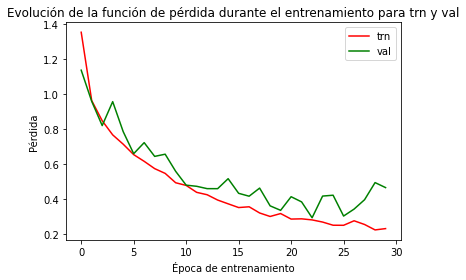

In [32]:
## Entrenamiento del modelo
trn_output = trn_function(training_epochs, learning_rate, criterion, optimizer, verbose=True, plot=True)

Si analizamos las funciones de pérdida, podemos ver que en el modelo modificado las curvas para validation y training están más pegadas, y esto implica que el modelo se está entrenando mucho mejor. Es más resistente al sobreentrenamiento que el modelo base y podría seguirse entrenando seguramente por algunas épocas más.

#### 3) Grafico la matriz de confusión para los datos de tst

Analizo la matriz de confusión nuevamente para ver diferencias respecto al modelo base

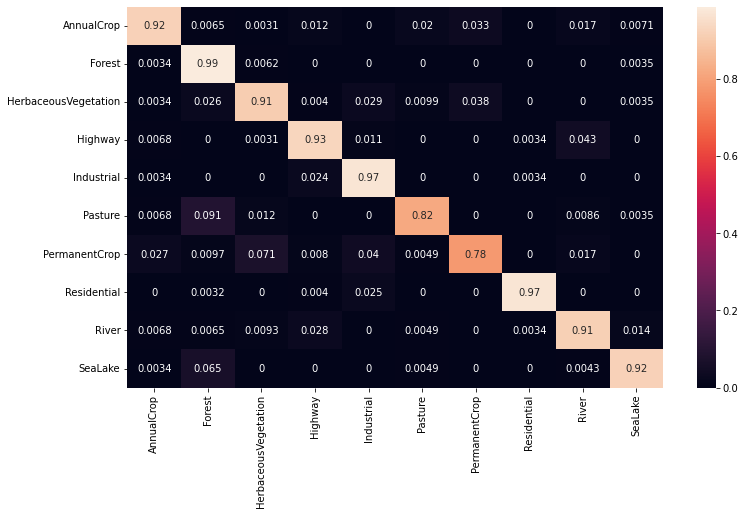

In [33]:
y_true, y_pred = crear_confusion_matrix(plot=True)

De comparar la matriz de confusión con la anterior podemos ver que no hay predicciones selectivas de algunas clases por sobre otras.

La confusión del algoritmo entre clases baja bastante. En particular, ya no se observan problemas entre las clases 3 y 6.

#### 4) Obtengo variables de performance del modelo

Calculo y muestro nuevamente las variables que definen la performance y los valores de AUC para las distintas clases

In [36]:
performance = calcular_performance(y_true, y_pred, verbose=True)

Performance del modelo para cada clase con el dataset de test

Precision: [0.93706294 0.82608696 0.89634146 0.92125984 0.90202703 0.94857143
 0.91666667 0.98954704 0.90987124 0.96654275] 

Recall: [0.91780822 0.98701299 0.90740741 0.93227092 0.97090909 0.81773399
 0.78242678 0.96928328 0.9137931  0.91872792]

f1: [0.92733564 0.89940828 0.90184049 0.92673267 0.9352014  0.87830688
 0.84424379 0.97931034 0.91182796 0.94202899]

accuracy: 0.917037037037037


Si miramos el accuracy para test y los vectores de precision, recall y f1, podemos ver que se no hay diferencias importantes respecto al modelo base.

Valor del área bajo la curva ROC para cada clase: 

[0.95516657 0.98012857 0.94654882 0.96205216 0.97947516 0.90706483
 0.88775951 0.98401846 0.95264209 0.95750215]


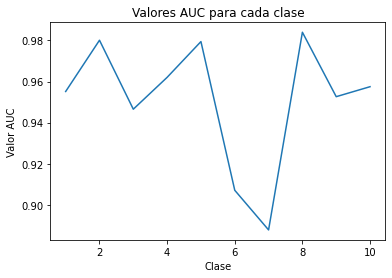

In [35]:
y_pred_one_hot = label_binarize(y_pred, classes=[*range(10)])
y_true_one_hot = label_binarize(y_true, classes=[*range(10)])

auc_v = roc_auc_score(y_true_one_hot, y_pred_one_hot, average=None)
print('Valor del área bajo la curva ROC para cada clase: \n\n{}'.format(auc_v))
plt.plot(np.arange(1,11), auc_v)
plt.title('Valores AUC para cada clase')
plt.xlabel("Clase")
plt.ylabel("Valor AUC")
plt.show()

De los valores de la métrica AUC, podemos ver que casi todas las clases (excepto las clases 6 y 7) tienen valores muy similares.

De analizas los resultados y los gráficos anteriores, podemos ver que no mejoraron sustancialmente los niveles de predicción para las distintas clases por haber agregado dos capas extras de convolución. Sin embargo, el modelo se hizo un poco más resistente al overfitting y se podría seguir entrenando un poco más.

Para mejorar un aún más la performance, se podría agregar una capa de neuronas full connected después de la última capa de convolución, que no agregué en esta prueba para que el modelo no me quede demasiado pesado y cueste mucho tiempo entrenarlo.

### FASE 4: Conclusiones del trabajo realizado

#### 1) En primer lugar se procedió a definir y separar los datasets de trn, val y tst. Se utilizó la proporción de samples (80%, 10%, 10%) porque es típica en este tipo de problemas cuando uno no sabe bien hasta que punto entrenar el modelo o cuando quiere realizar un early stopping.

#### 2) Se definió el modelo base con las capas requeridas y se lo entrenó adoptando un learning rate de 0.001 (valor típico inicial) por 50 épocas.

#### 3) Se graficaron las funciones de pérdida o costo, la matriz de confusión y se obtuvieron variables de performance para analizar los resultados del modelo.

#### 4) Se concluyó que el desbalance importante de cantidad de samples en los datos introdujo un sesgo en el entrenamiento, ya que los valores de recall y precision para algunas clases eran demasiado bajos. Se determinó que el modelo comenzaba a sobreentrenarse alrededor de las 20 épocas.

#### 5) Para disminuir tanto el problema del sobreentrenamiento como el overfitting, se decidió utilizar data augmentation con la librería OpenCV vía rotaciones y espejados y transformaciones de pytorch sobre el dataset de trn. De esta forma, al agregarle complejidad al momento de entrenarse y balance de clases, es menos probable un sesgo y un sobreentrenamiento.

#### 6) Se reentrenó el modelo y se verificó que la exactitud creció, dejó de sobreentrenarse tan temprano y empezó a predecir con una importancia más pareja las distintas clases. Esto implica que los recursos computacionales se utilizaron en forma más pareja en lugar de concentrarlos en clases partitulares. Otro método que a veces se suele utilizar es agregar pesos relativos a las distintas clases cuando se define la función de pérdida o costo. Sin embargo, el método de data augmentation, que en este tipo de datasets se puede aplicar, permite también reducir terriblemente el overfitting, por lo cual se lo suele escoger por sobre los pesos por clases.

#### 7) Se agregaron capas de convolución al modelo para tratar de mejorar la performance, y se concluyó que se logró mejorar un poco resistencia del modelo al overfitting y se logró disminuir la confusión del modelo entre algunas clases donde tenía problemas. Comparando el accuracy obtenido al valor publicado en el paper de referencia y comparando también la matriz de confusión con la reportada en el paper, se puede concluir que el modelo propuesto se entrena bastante bien.

#### 8) Respecto al paper de referencia, los autores realizaron un primer entrenamiento con otro dataset y un segundo entrenamiento refinando el anterior a partir del dataset EuroSAT aquí utilizado. Es por eso que en general obtuvieron resultados mucho mejores, con una exactitud global mayor al 98%. Para realizar una comparación o bechmark más preciso, se podría hacer un pre-entrenamiento con los mismos datos que usaron ellos.